In [23]:
# Setup - import library and load data from local file
import pandas as pd
backgrounds = pd.read_csv("data/background_survey.csv")
backgrounds

,biological_education,bio_database_experience,Any biological software tools you'd like to add to the list? How often do you use it?,years_experience,biological_education.1,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,years_experience.1
0,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,15
1,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,2
2,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,17
3,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,9
4,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",18
5,doctoral,galaxy = heard_of;gnomad = never_heard;intermi...,BEAST - few times a yearPAML - every weekfigtr...,13,informal,r_lang = every_week;python = every_day;perl = ...,,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,5
6,doctoral,galaxy = every_day;gnomad = never_heard;interm...,Aequatus and GeneSeqToFamily: Daily,12,masters,r_lang = heard_of;python = every_week;perl = e...,,Newick;GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Goo...,12
7,doctoral,galaxy = every_day;gnomad = year_or_less;inter...,BLAST (few times a year)BWA/BOWTIE/various RNA...,13,masters,r_lang = year_or_less;python = every_day;perl ...,,GFF;FASTA;VCF;BAM;CSV / TSV,18
8,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview. Clustal. RAxML, Cytoscape, Chimera, P...",15,doctoral,r_lang = year_or_less;python = every_week;perl...,,Phylip;FASTA;PDB,10
9,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview Proviz, often for teaching",11,doctoral,r_lang = year_or_less;python = every_week;perl...,,I have not actively done research in the last ...,7


In [24]:
#"split a multi choice answer, returning a series with a column 
# header and the responses with the header stripped out."
def split_multi_choice( a_series, series_prefix ):
    # variable to store the final response in as we build it
    response = list()
    # Multi-choice answer sets are separated by ; in SelectSurvey
    series_as_df = a_series.str.split(";",expand=True)
    # extract the name of each column and throw it out, 
    # as it's recorded once per row, which is a bit excessive - 
    # we can just keep it as a column header instead
    for i in series_as_df:
        answer = series_as_df[i]
        split_answer = pd.DataFrame(answer.str.split("=",expand=True))
        
        series_name = series_prefix + "_" + split_answer[0][0] # the 0th value of this is the same for every column
        series_content = split_answer[1]
        
        # add the split responses in to a single column
        returnSeries = pd.Series(data=series_content, name=series_name)
        
        # glue the column into the object we'll be returning
        response.append(returnSeries)
    return pd.DataFrame(response).transpose()


In [25]:
# computationally split-out-able vars: 
bio_software = split_multi_choice(backgrounds.bio_database_experience, "bio_software")
computer_experience = split_multi_choice(backgrounds.computer_experience, "computer_experience")

# preview var
bio_software

,bio_software_galaxy,bio_software_gnomad,bio_software_intermine,bio_software_biomart,bio_software_molgenis,bio_software_knetminer,bio_software_genecards,bio_software_go,bio_software_ensembl,bio_software_ncbi,bio_software_pdb,bio_software_biogrid,bio_software_interpro,bio_software_kegg,bio_software_reactome
0,every_day,never_heard,never_heard,heard_of,never_heard,never_heard,never_heard,heard_of,every_month,every_week,heard_of,never_heard,year_or_less,heard_of,heard_of
1,every_day,never_heard,heard_of,heard_of,never_heard,never_heard,year_or_less,every_month,year_or_less,every_week,year_or_less,heard_of,heard_of,year_or_less,year_or_less
2,every_month,never_heard,heard_of,year_or_less,never_heard,never_heard,every_week,every_week,every_week,every_day,every_month,heard_of,every_week,year_or_less,year_or_less
3,heard_of,never_heard,never_heard,heard_of,never_heard,never_heard,heard_of,heard_of,every_day,every_month,heard_of,never_heard,year_or_less,never_heard,heard_of
4,every_week,heard_of,year_or_less,year_or_less,heard_of,year_or_less,never_heard,every_month,every_month,every_week,year_or_less,never_heard,year_or_less,heard_of,heard_of
5,heard_of,never_heard,never_heard,every_day,heard_of,never_heard,heard_of,every_week,every_day,every_day,never_heard,year_or_less,year_or_less,year_or_less,year_or_less
6,every_day,never_heard,year_or_less,every_month,heard_of,never_heard,never_heard,heard_of,every_day,every_month,every_month,never_heard,year_or_less,year_or_less,heard_of
7,every_day,year_or_less,year_or_less,year_or_less,never_heard,heard_of,year_or_less,year_or_less,every_month,every_month,year_or_less,year_or_less,year_or_less,year_or_less,year_or_less
8,year_or_less,never_heard,year_or_less,year_or_less,never_heard,never_heard,year_or_less,every_month,every_month,every_day,every_week,heard_of,every_week,year_or_less,year_or_less
9,year_or_less,never_heard,heard_of,heard_of,never_heard,never_heard,year_or_less,every_month,year_or_less,every_month,year_or_less,heard_of,every_month,year_or_less,year_or_less


In [26]:
# re-append these two split-out columns into the dataframe
expanded_backgrounds = backgrounds.join(bio_software).join(computer_experience)
# I'd like to remove the bio experience and computer 
# experience columns I split out but I can't google it in the plane ..

In [27]:
#rename some badly named columns. Oopsie.

columns_to_rename = {
    "Any biological software tools you'd like to add to the list? How often do you use it?" : "software_tools_freetext",
    "years_experience" : "biology_years_experience",
    "years_experience.1" : "computer_years_experience",
    #why won't this one rename? other ones have ?s in them... 
    "What file types do you commonly use for biological data?" : "bio_file_types_freetext",
    "biological_education.1" : "computer_education"
}

expanded_backgrounds = expanded_backgrounds.rename(columns = columns_to_rename )

expanded_backgrounds


,biological_education,bio_database_experience,software_tools_freetext,biology_years_experience,computer_education,computer_experience,programming_langs_free_text,What file types do you commonly use for biological data?,computer_years_experience,bio_software_galaxy,...,computer_experience_python,computer_experience_perl,computer_experience_java,computer_experience_rdbm,computer_experience_functional_language,computer_experience_graph_db,computer_experience_semantic,computer_experience_html,computer_experience_js,computer_experience_git
0,highschool,galaxy = every_day;gnomad = never_heard;interm...,,10,doctoral,r_lang = every_month;python = every_day;perl =...,C/C++,GFF;FASTA;BAM;CSV / TSV,15,every_day,...,every_day,year_or_less,year_or_less,year_or_less,heard_of,heard_of,heard_of,year_or_less,year_or_less,every_week
1,doctoral,galaxy = every_day;gnomad = never_heard;interm...,MaxQuant Every monthCardinal Everz weak,7,informal,r_lang = every_week;python = year_or_less;perl...,,mzml and imzml;FASTA;CSV / TSV,2,every_day,...,year_or_less,heard_of,heard_of,heard_of,heard_of,never_heard,never_heard,heard_of,heard_of,every_week
2,doctoral,galaxy = every_month;gnomad = never_heard;inte...,BLAST - every weekPUBCHEM - every month,17,informal,r_lang = year_or_less;python = every_month;per...,MongoDBC/C++,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,17,every_month,...,every_month,every_day,heard_of,every_week,never_heard,never_heard,year_or_less,every_week,heard_of,every_day
3,masters,galaxy = heard_of;gnomad = never_heard;intermi...,Omim - every monthClinVar - every monthENA - e...,11,masters,r_lang = year_or_less;python = every_day;perl ...,,FASTA;VCF;BAM;CSV / TSV;Excel / Google Sheets ...,9,heard_of,...,every_day,every_month,year_or_less,every_day,heard_of,heard_of,heard_of,year_or_less,heard_of,every_week
4,doctoral,galaxy = every_week;gnomad = heard_of;intermin...,"Ensembl REST API, BLAST, PyANI, CyVerse (US/UK)",21,doctoral,r_lang = every_day;python = every_day;perl = e...,"bash shell, GNU tools (awk, sed, curl, etc), jq","JSON, RDF;FASTA;VCF;BAM;CSV / TSV;Excel / Goog...",18,every_week,...,every_day,every_day,every_day,every_day,year_or_less,every_month,every_day,every_day,every_day,every_day
5,doctoral,galaxy = heard_of;gnomad = never_heard;intermi...,BEAST - few times a yearPAML - every weekfigtr...,13,informal,r_lang = every_week;python = every_day;perl = ...,,GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Google She...,5,heard_of,...,every_day,heard_of,year_or_less,year_or_less,never_heard,heard_of,never_heard,year_or_less,never_heard,year_or_less
6,doctoral,galaxy = every_day;gnomad = never_heard;interm...,Aequatus and GeneSeqToFamily: Daily,12,masters,r_lang = heard_of;python = every_week;perl = e...,,Newick;GFF;FASTA;VCF;BAM;CSV / TSV;Excel / Goo...,12,every_day,...,every_week,every_month,every_week,every_week,never_heard,never_heard,never_heard,every_week,every_week,every_week
7,doctoral,galaxy = every_day;gnomad = year_or_less;inter...,BLAST (few times a year)BWA/BOWTIE/various RNA...,13,masters,r_lang = year_or_less;python = every_day;perl ...,,GFF;FASTA;VCF;BAM;CSV / TSV,18,every_day,...,every_day,year_or_less,year_or_less,every_week,heard_of,heard_of,heard_of,every_month,year_or_less,every_day
8,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview. Clustal. RAxML, Cytoscape, Chimera, P...",15,doctoral,r_lang = year_or_less;python = every_week;perl...,,Phylip;FASTA;PDB,10,year_or_less,...,every_week,every_month,year_or_less,year_or_less,heard_of,never_heard,never_heard,every_month,heard_of,every_month
9,doctoral,galaxy = year_or_less;gnomad = never_heard;int...,"Jalview Proviz, often for teaching",11,doctoral,r_lang = year_or_less;python = every_week;perl...,,I have not actively done research in the last ...,7,year_or_less,...,every_week,year_or_less,year_or_less,year_or_less,heard_of,never_heard,heard_of,year_or_less,year_or_less,every_week


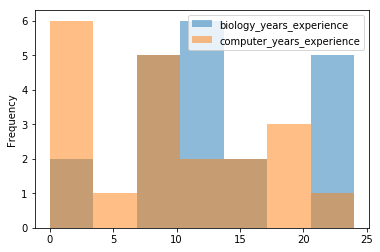

In [28]:
# This plot seems like nonsense, but I'll leave it here to remind me
# since I thought it would be awesome and I'll keep on forgetting otherwise.
expanded_backgrounds.plot.hist(bins=7,alpha=0.5)

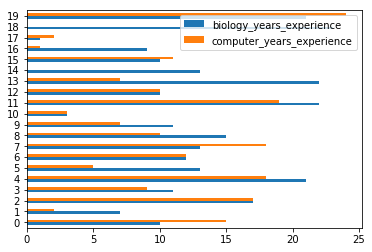

In [29]:
expanded_backgrounds.plot.barh()

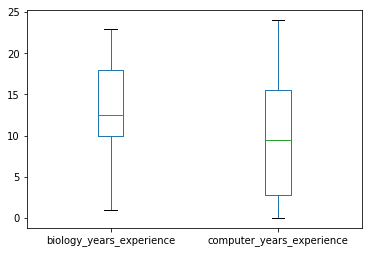

In [30]:
expanded_backgrounds.plot.box()

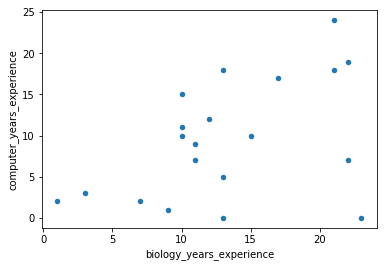

In [31]:
#bio xp (years) vs computer xp (years)
expanded_backgrounds.plot.scatter(x="biology_years_experience", y="computer_years_experience")

In [32]:
## Todo: add my "desired" people areas to this plot.

### Formal education levels

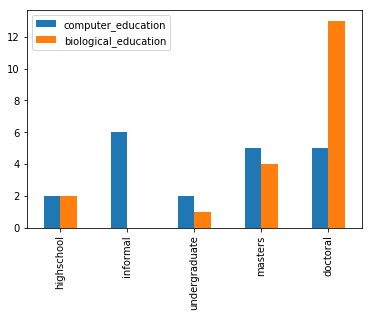

In [33]:
# bio xp (formal education) vs computer xp (formal education)

# First, set up the data categories
#question to self - did I include undergrad in this scale in the questionnaire??
degree_order = ["highschool", "informal", "undergraduate", "masters", "doctoral"]

# add category datatypes and make sure it's ordinal
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].astype("category")
expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].astype("category")

expanded_backgrounds["computer_education"] = expanded_backgrounds["computer_education"].cat.set_categories(degree_order, ordered=True)
expanded_backgrounds["biological_education"] = expanded_backgrounds["biological_education"].cat.set_categories(degree_order, ordered=True)

#we want to just get the counts of who has which level. 
computer_formal = expanded_backgrounds["computer_education"].value_counts()
bio_formal = expanded_backgrounds["biological_education"].value_counts()

# in order to plot this as a bar chart, we want a df 
# with the categories as the labels and the values as rows
both_formal = pd.DataFrame([computer_formal, bio_formal])

# order based on the degree classification
both_formal = both_formal.T.sort_index()

#visualise
both_formal.plot.bar()

In [34]:
# convert the formal education levels to a number in order to fake a plot...
# once I've looked it up online there might be a better way to do this? 
levels = {
    "highschool" : 1, 
    "informal" : 2, 
    "undergraduate" : 3, 
    "masters": 4, 
    "doctoral": 5
}


bio_numberwise = expanded_backgrounds["biological_education"]
computer_numberwise = expanded_backgrounds["computer_education"]

bio_numberwise = bio_numberwise.map(levels)
computer_numberwise = computer_numberwise.map(levels)
computer_numberwise


0     5
1     2
2     2
3     4
4     5
5     2
6     4
7     4
8     5
9     5
10    3
11    4
12    5
13    1
14    2
15    4
16    2
17    2
18    1
19    3
Name: computer_education, dtype: int64

                      0   1   2   3   4   5   6   7   8   9   10  11  12  13  \
biological_education   1   5   5   4   5   5   5   5   5   5   3   4   5   5   
computer_education     5   2   2   4   5   2   4   4   5   5   3   4   5   1   

                      14  15  16  17  18  19  
biological_education   5   5   4   4   5   1  
computer_education     2   4   2   2   1   3  


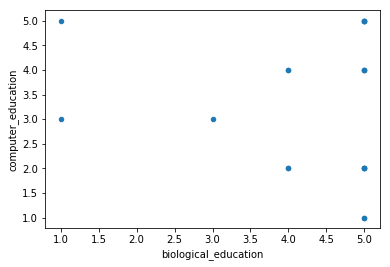

In [35]:
#visualise a scatterplot of formal bio vs computational

formal_scatter_data = pd.DataFrame(data=[bio_numberwise,computer_numberwise])

print(formal_scatter_data)


formal_scatter_data.T.plot.scatter(x="biological_education", y="computer_education")

### TODO 
- map by
    - education level bio v computer (x/y scatterplot)
    - xp level - number of years. (scatterplot)
    - histograms for counts of
        - stuff. um.
- rename some of the columns. 
    - SRSLY THIS IS A COLUMNS NAME?! Any biological software tools you'd like to add to the list? How often do you use it?
    - experience level - bio vs computers. name the columns clearly for each, kthx
    - "What file types do you commonly use for biological data?" also rename pls. 


### Questions 
- How should I analyse the computer experience? how does one cluster a heatmap sensibly?


In [36]:
#extract free text answers for further annotation
# 
free_text_bio = backgrounds["Any biological software tools you'd like to add to the list? How often do you use it?"]
#nice try but this doesn't work - I need api docs and can't get any on the plane
pd.write_csv("data/test.csv", free_text_bio)


AttributeError: module 'pandas' has no attribute 'write_csv'